In [5]:
import pandas as pd
from pandas import Timestamp
import numpy as np
from operator import itemgetter
from datetime import datetime
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from ast import literal_eval
import joblib

from tqdm import tqdm
tqdm.pandas()
from scipy import sparse
from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

# Sentiment Analysis

In [ ]:
df = pd.read_csv('/Users/francesco/df2')

In [ ]:
df.shape

In [ ]:
analyzer = SentimentIntensityAnalyzer()
vader_scores = df['text'].map(analyzer.polarity_scores) # Calculate sentiment analysis (2h 18).

In [ ]:
vader_scores.head()

In [ ]:
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores) # Sparse matrix
vader_scores

In [ ]:
dvec.feature_names_
for i, col in enumerate(dvec.feature_names_):
    df['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [ ]:
df.head()

In [ ]:
df.to_csv('/Users/francesco/df2_sent', encoding='utf-8', index=False) # In case later parts break.

# Part of Speech Tagging

In [ ]:
df = pd.read_csv('/Users/francesco/df2_sent')

In [ ]:
def text_vec(x):
    '''Calculate the POS tags for each word in text.'''
    try:
        return [count for tag, count in sorted(
            add_pos_with_zero_counts(
                Counter(list(zip(*x))[1]), 
                    possible_tags).most_common()
                    )]
    except:
        return ('error')
    
df['text_vector'] = df['tagged_text'].apply(lambda x: text_vec(x))

In [ ]:
df_pos_tags.shape # May need to be saved now to clear memory space

In [ ]:
type(df_pos_tags[0])

In [ ]:
pos_tags = df_pos_tags.progress_apply(lambda x: literal_eval(x)) # Converts strings back into list.

In [ ]:
pos_tags

In [ ]:
tags = []
for i, tag in enumerate(pos_tags):
    try:
        tags.append(np.array(pos_tags[i])[:, 1])
    except:
        tags.append(np.array(pos_tags[0])[:, 1]) #If ever occurs, place in tags of pos_tags(0) - very rare


In [ ]:
counts = [dict(Counter(tag)) for tag in tags] # Count the tags.

In [ ]:
df_pos_tags_count = pd.DataFrame(counts)

In [ ]:
df_pos_tags_count.head()

In [ ]:
df_pos_tags_count.fillna(0, inplace=True) # Turn to sparse. 

In [ ]:
df_pos_tags_count.shape

In [ ]:
df_pos_tags_count.to_csv('/Users/francesco/df_pos_tags_count_8', encoding='utf-8', index=False) # Save for later

In [ ]:
df_sent = pd.read_csv('/Users/francesco/df2_sent')

In [ ]:
df = pd.concat([df_sent, df_pos_tags_count], axis=1)

In [ ]:
df.drop(['#', '$', "''", ':', '``'], axis=1, inplace=True)

In [ ]:
df.to_csv('/Users/francesco/df2_sent_pos', encoding='utf-8', index=False) # Final dataframe for modelling.

# Pre Modelling

In [3]:
df = pd.read_csv('/Users/francesco/df2_sent_pos')

In [4]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text,word_count,vader_compound,vader_neg,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,people who have lived with anxiety long term w...,157,-0.2757,0.154,...,4.0,1.0,5.0,9.0,14.0,7.0,0.0,5.0,0.0,3.0
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,arm body twitches whenever i am having about t...,28,-0.9036,0.336,...,3.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,0.0,2.0
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,coping techniques i am a freshman in high scho...,183,0.9840,0.062,...,17.0,6.0,6.0,1.0,13.0,11.0,0.0,0.0,0.0,1.0
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,at what point do you surrender to the anxiety ...,270,0.8271,0.089,...,18.0,3.0,7.0,9.0,15.0,10.0,0.0,2.0,0.0,0.0
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,shower anxiety - any tips i have been having s...,395,-0.9024,0.120,...,14.0,2.0,11.0,8.0,30.0,17.0,4.0,0.0,0.0,3.0


In [5]:
df.subreddit.value_counts()

depression      413484
SuicideWatch    159198
Anxiety         141082
bipolar          71875
Name: subreddit, dtype: int64

In [6]:
df.shape

(785639, 48)

In [8]:
df.columns

Index(['author', 'created_utc', 'subreddit', 'num_comments', 'score', 'date',
       'text', 'word_count', 'vader_compound', 'vader_neg', 'vader_neu',
       'vader_pos', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
       'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$',
       'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN',
       'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'],
      dtype='object')

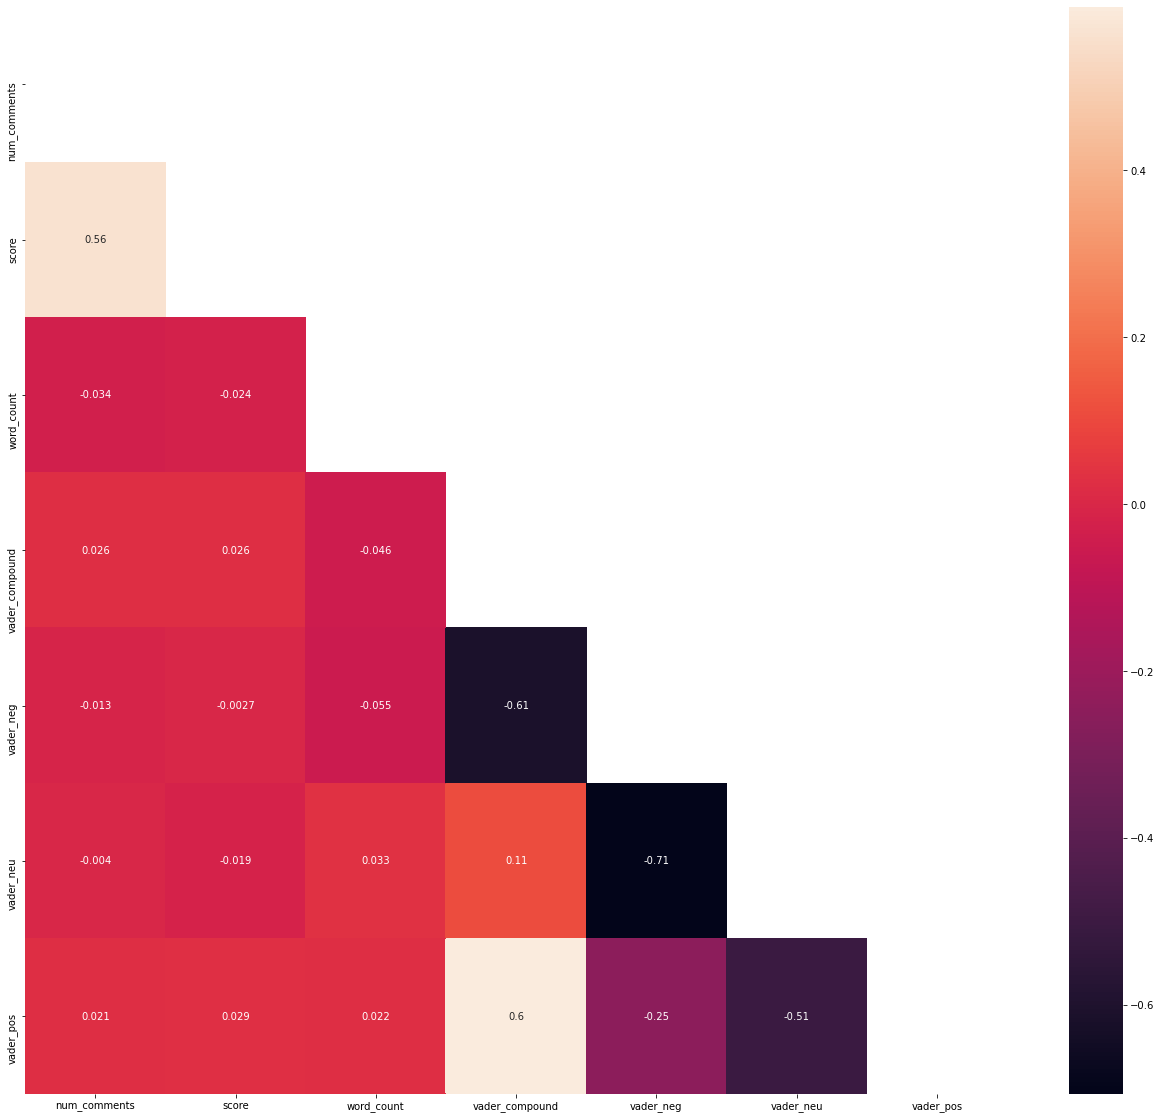

In [9]:
'''
Heat Map / correlation 
'''
test_corr = df[['num_comments', 'score', 'word_count',
               'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos']].corr()

# Set the  matplotlib figure size:
fig, ax = plt.subplots(figsize=(22, 20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(test_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(test_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([test_corr.shape[1], 0])
plt.show()

In [10]:
df.drop(['vader_neg', 'vader_neu', 'vader_pos'], axis=1, inplace=True)

In [11]:
df.shape

(785639, 45)

In [12]:
df.columns

Index(['author', 'created_utc', 'subreddit', 'num_comments', 'score', 'date',
       'text', 'word_count', 'vader_compound', 'CC', 'CD', 'DT', 'EX', 'FW',
       'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT',
       'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB',
       'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'],
      dtype='object')

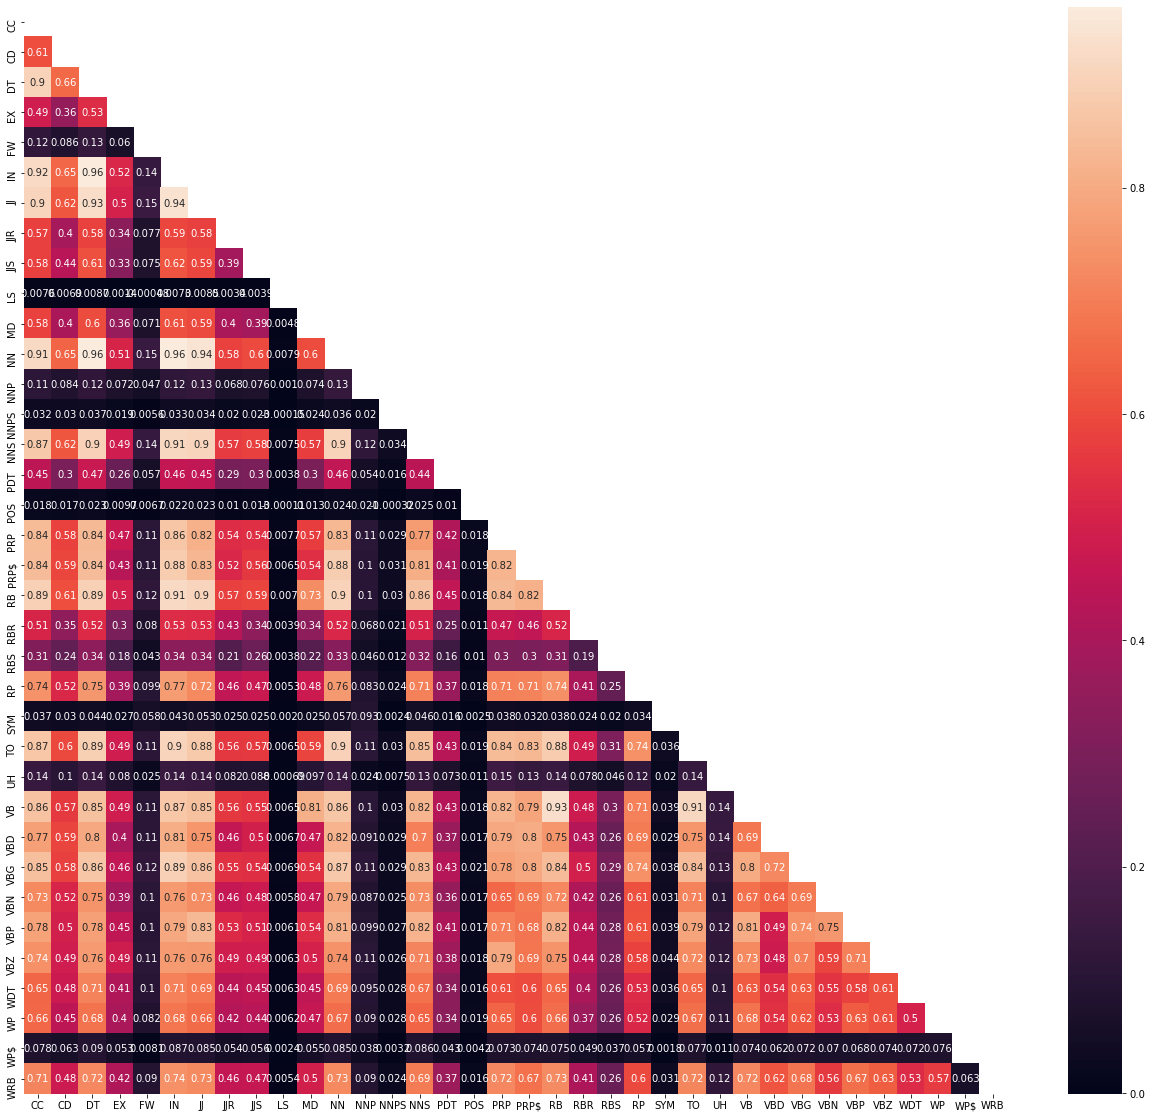

In [13]:
'''
Heat Map / correlation 
'''
corr_mat = df.loc[:, df.columns[9:]].corr()

# Set the  matplotlib figure size:
fig, ax = plt.subplots(figsize=(22, 20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(corr_mat, mask=mask, annot=True, ax=ax)
ax.set_ylim([corr_mat.shape[1], 0])
plt.show()

In [14]:

upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['IN', 'NN']

In [15]:
df.drop(to_drop, axis=1, inplace=True)

In [16]:
df.shape

(785639, 43)

In [18]:
X = pd.concat([df['text'], df.loc[:, ~df.columns.isin(['author', 'created_utc', 'subreddit', 'date', 'text'])].astype(float)], axis=1)
y = df['subreddit']